In [2]:
import os
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid

In [3]:
def load_pickle(path):
  with open(path, 'rb') as f:
    data = pickle.load(f)
  train_data, test_data = data['train'], data['test']
  return train_data, test_data


def show_samples(samples, title, nrow=10):
  samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
  grid_img = make_grid(samples, nrow=nrow)
  plt.figure()
  plt.title(title)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')
  plt.show()


def visualize_data(data, title):
  idxs = np.random.choice(len(data), replace=False, size=(100,))
  images = train_data[idxs]
  show_samples(images, title)

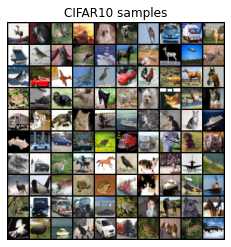

In [4]:
train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'cifar10.pkl'))
visualize_data(train_data, 'CIFAR10 samples')

In [5]:
def train_epoch(model, train_loader,optimizer,epoch,loss_key='total'):
  model.train()
  stats = defaultdict(list)
  for x in train_loader:
    #x = Variable(x)# cuda
    optimizer.zero_grad()
    losses = model.loss(x)
    losses[loss_key].backward()
    optimizer.step()

    for k,v in losses.items():
      stats[k].append(v.item())
  return stats

In [6]:
def eval_model(model, data_loader):
  model.eval()
  stats = defaultdict(float)
  with torch.no_grad():
    for x in data_loader:
      #x = Variable(x)
      if False:
        x = x.cuda()
      losses = model.loss(x)
      for k,v in losses.items():
        stats[k]+=v.item()*x.shape[0]
    
    for k in stats.keys():
      stats[k] /= len(data_loader.dataset)
  return stats

In [7]:
def train_model(model, train_loader, test_loader, epochs, lr, loss_key='total'):
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  train_losses = defaultdict(list)
  test_losses =  defaultdict(list)
  for epoch in range(epochs):
    model.train()
    train_loss = train_epoch(model,train_loader,optimizer,epoch,loss_key)
    test_loss = eval_model(model,test_loader)

    for k in train_loss.keys():
      train_losses[k].extend(train_loss[k])
      test_losses[k].append(test_loss[k])
  return dict(train_losses), dict(test_losses)

In [8]:
def plot_training_curves(train_losses, test_losses):
  n_train = len(train_losses[list(train_losses.keys())[0]])
  n_test = len(test_losses[list(train_losses.keys())[0]])
  x_train = np.linspace(0, n_test - 1, n_train)
  x_test = np.arange(n_test)

  plt.figure()
  for key, value in train_losses.items():
    plt.plot(x_train, value, label=key + '_train')

  for key, value in test_losses.items():
    plt.plot(x_test, value, label=key + '_test')

  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [9]:
class ConvEncoder(nn.Module):
  def __init__(self, input_shape, n_latent):
    super().__init__()
    self.input_shape = input_shape
    self.n_latent = n_latent
    self.convs = nn.Sequential(nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
      )
    conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
    self.fc = nn.Linear(conv_out_dim, 2 * n_latent)

  def forward(self, x):
    out = self.convs(x)
    out = out.view(out.shape[0], -1)
    mu, log_std = self.fc(out).chunk(2, dim=1)
    return mu, log_std
        


In [10]:
class ConvDecoder(nn.Module):
  def __init__(self, n_latent, output_shape):
    super().__init__()
    self.n_latent = n_latent
    self.output_shape = output_shape

    self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
    self.fc = nn.Linear(n_latent, np.prod(self.base_size))
    self.deconvs = nn.Sequential(nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
    )

  def forward(self, z):
    out = self.fc(z)
    out = out.view(out.shape[0], *self.base_size)
    return self.deconvs(out)

In [11]:
class ConvVAE(nn.Module):
  def __init__(self, input_shape, n_latent):
    super().__init__()
    assert len(input_shape) == 3

    self.input_shape = input_shape
    self.n_latent = n_latent
    self.encoder = ConvEncoder(input_shape, n_latent)
    self.decoder = ConvDecoder(n_latent, input_shape)

  def prior(self, n):
    return torch.randn(n, self.n_latent)#.cuda()


  def forward(self, x):
    mu_z, log_std_z = self.encoder(x)
    z = mu_z + self.prior(x.shape[0])*log_std_z.exp()
    #latent = torch.randn_like(mu_z)*log_std_z.exp() + mu_z
    x_recon = self.decoder(z)
    return mu_z, log_std_z, x_recon
        
  def loss(self, x):
    mu_z, log_std_z, x_recon = model(x)
    # use F.mse_loss for recon_loss
    recon_loss = F.mse_loss(x,x_recon,reduction='sum')
    kl_loss = 0.5*(log_std_z.exp()**2 + mu_z.pow(2) - 1 - log_std_z) 
    kl_loss = kl_loss.sum(1).mean()

    return {
        'elbo_loss': recon_loss + kl_loss, 
        'recon_loss': recon_loss,
        'kl_loss': kl_loss
    }

  def sample(self, n):
    with torch.no_grad():
      z = self.prior(n)
      x_recon = self.decoder(z)
      samples = torch.clamp(x_recon, -1, 1)
    return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3

train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'cifar10.pkl'))

train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255. * 2 - 1).astype('float32')
test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255. * 2 - 1).astype('float32')

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), 16)#.cuda()
train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)



In [17]:
samples = model.sample(100) * 255.

x = next(iter(test_loader))[:50]#.cuda()
with torch.no_grad():
  z, _ = model.encoder(x)
  x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

elbo_loss: 575.1245
recon_loss: 570.7407
kl_loss: 4.3838


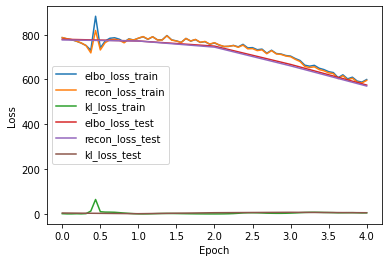

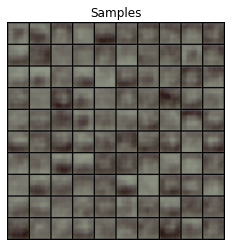

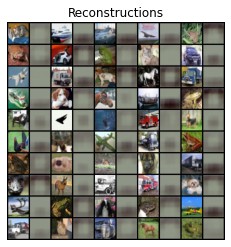

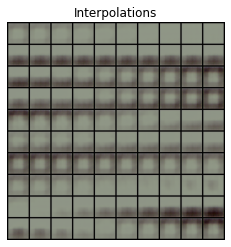

In [18]:
x = next(iter(test_loader))[:20]#.cuda()
with torch.no_grad():
  z, _ = model.encoder(x)
  z1, z2 = z.chunk(2, dim=0)
  interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
  interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
  interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

samples, reconstructions, interps = samples.astype('float32'), reconstructions.astype('float32'), interps.astype('float32')
for key, value in test_losses.items():
  print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')
show_samples(interps, title='Interpolations')